## v1.0: FFN Regression | 1 row as input

### Importing Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 110)
import numpy as np
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder
%matplotlib inline

### Processing Train Data

In [2]:
df = pd.read_csv("train_data.csv")

# Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)

# Filtering events with len=1 or min_tca > 2 or max_tca < 2
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].min()<2.0)
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].max()>2.0)

# OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

# Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

df

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
9,2,6.983474,0,0,0,0,1,-10.816161,-6.601713,13.293159,22902.0,14348.0,-1157.6,-6306.2,21986.3,15.8,-13792.0,-3957.1,1.0,0.0,3.92,3.92,444,442,99.4,1.094,3.4505,0.025520,0.009390,0.000019,7158.394530,0.000860,98.523094,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.396928,0.001367,69.717278,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,12.0,2.0,786.417082,774.097978,800.056782,780.463075,63.955771,-16.008858,-0.063092,115.208802,4.110620e+06,2.715773e+18,9.039007,257.208281,147.615141,38173.433170,1.642649,218.243786,0.153332,39.695541,0.009370,0.269965,0.003886,0.339406,73.0,77.0,27.0,4.0,0,0,0,0,1
10,2,6.691611,0,0,0,0,1,-10.850473,-6.603452,13.374242,22966.0,14348.0,-1161.1,-6330.2,22046.3,15.8,-13792.0,-3957.1,1.0,0.0,3.86,3.86,444,442,99.4,1.099,3.4505,0.024168,0.010812,0.000017,7158.394561,0.000861,98.523097,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.397641,0.001367,69.717278,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,12.0,2.0,786.420510,774.094612,800.057080,780.464203,63.956674,-16.008858,-0.063092,101.429474,1.158624e+07,2.704770e+18,8.994890,257.185050,242.290796,38098.346421,1.675557,218.238631,0.252043,39.617319,0.009373,0.269926,0.003939,0.339393,73.0,77.0,27.0,4.0,0,0,0,0,1
11,2,6.269979,0,0,0,0,1,-30.000000,-6.217958,426.808532,18785.0,14347.0,-698.8,-5176.4,18044.8,14.4,-13791.4,-3957.2,1.0,0.0,3.85,3.85,447,445,99.4,1.113,3.4505,0.023038,0.009797,0.000016,7158.407962,0.000862,98.523100,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,1.0,0.0,14.63,14.63,15.0,15.0,100.0,1.641,0.849987,0.476139,0.000712,7168.395887,0.001297,69.718437,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,12.0,2.0,786.439755,774.102169,799.554662,780.963112,63.903391,-16.009902,-0.057504,177.272242,3.780413e+06,7.644201e+13,9.927960,48.396653,121.934573,2521.604251,1.824402,86.921700,0.126831,2.616

In [3]:
df.describe()

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
count,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,1.434530e+05,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,140572.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,136024.000000,143442.000000,143442.000000,143442.000000,143442.000000,143442.00000,143442.000000,143442.000000,143442.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143442.000000,143442.000000,143442.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,136013.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000,1.434530e+05,1.434530e+05,1.434530e+05,1.434530e+05,1.434420e+05,1.434530e+05,1.434420e+05,1.434530e+05,1.434420e+05,136024.000000,136013.000000,136024.000000,136013.000000,136024.000000,136013.000000,137420.000000,137420.000000,137420.000000,137420.000000,143453.000000,143453.000000,143453.000000,143453.000000,143453.000000
mean,6559.365827,3.233743,0.003932,0.145065,0.473744,0.445059,0.694911,-20.000185,-6.244755,5.924078e+04,15991.869344,10692.382383,-41.205550,16.378969,100.995615,0.435514,-8809.784948,-68.319261,1.009243,0.000606,4.047741,3.856442,973.536496,935.164932,98.939384,1.119225,2.941948,0.013302,0.011419,0.000104,7042.571144,0.001872,95.395400,-0.092509,0.137990,0.001663,0.083666,-0.975319,0.000378,-0.976123,0.039681,-0.142502,-0.043481,0.062541,0.001761,0.210244,-0.000282,-0.063524,37.846607,0.564828,12.698980,12.111053,67.79681,60.999387,98.800496,1.967234,0.719114,0.316748,0.002310,7185.136390,0.014698,86.756311,-0.214640,0.112063,0.015007,0.206117,-0.981034,-0.008694,-0.872232,0.166030,-0.132499,-0.165946,0.172149,-0.000774,0.279273,0.002913,-0.191193,8.904203,2.355953,677.600209,651.268080,986.410055,627.588724,-0.636753,-0.162035,-0.019620,2.004365e+02,8.973069e+44,1.123041e+45,8.501100e+05,1.064311e+06,8.504248e+05,1.085876e+06,8.501067e+05,1.064132e+06,1053.937944,1169.937575,1053.675149,1146.897452,1053

In [4]:
# Getting y (last row of each event_id)
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)
print(y.shape)
y

(8892, 1)


array([[-30.        ],
       [-30.        ],
       [-27.65091683],
       ...,
       [-30.        ],
       [-30.        ],
       [ -7.1723723 ]])

In [5]:
# Getting X 
# Dropping rows with tca < 2 
X = df.loc[df["time_to_tca"]>2]

# Get last row
X = X.sort_values('time_to_tca',ascending=False).groupby('event_id').tail(1)
X = X.sort_values('event_id')

# First Approach: Drop all columns with any NaN value
X = X.dropna(axis=1, how='any')

# Set event_id as index
X.set_index("event_id", inplace=True)

X

,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.340627,0,0,0,0,1,-30.000000,-6.266241,401.442549,18763.0,14347.0,-692.9,-5175.6,18022.2,14.4,-13791.4,-3957.2,1.0,0.0,3.49,3.49,501,500,98.9,1.059,0.019173,0.010743,0.000013,7158.408291,0.000863,98.523084,-0.051871,0.208553,0.036837,180.0,2.0,16.59,16.59,18.0,18.0,100.0,1.689,0.850363,0.474344,0.000693,7168.395618,0.001295,69.718480,-0.159121,0.540554,-0.046394,12.0,2.0,786.446298,774.096284,799.542232,780.975003,63.903222,-16.009902,-0.057504,227.820615,4.006767e+04,1.214045e+14,4.577326,51.249088,31.686243,2922.327839,1.414729,88.676852,0,0,0,0,1
3,2.278941,0,0,0,1,0,-30.000000,-7.320481,140.001151,23900.0,13574.0,26.3,10072.2,21674.9,-39.7,-12310.9,5718.9,1.0,0.0,7.56,7.56,240,238,99.9,1.118,0.015909,0.008274,0.000019,7083.606025,0.002115,98.151372,-0.598082,0.268787,-0.163112,180.0,2.0,17.17,17.17,15.0,15.0,100.0,2.484,0.418293,0.141765,0.000487,7070.079861,0.004569,70.872300,-0.451050,0.830112,-0.026392,1.5,2.0,720.452161,690.485888,724.249394,659.636329,-69.883198,24.916732,0.167568,287.224245,7.401362e+06,3.423533e+13,8.516651,59.235817,101.164964,3764.712472,4.090482,73.758993,1,0,0,0,0
4,3.066467,0,0,0,1,0,-30.000000,-7.661743,434.669432,33593.0,12093.0,163.6,-19727.8,27190.5,25.8,-9788.5,-7101.8,1.0,0.0,7.03,7.03,294,294,99.8,1.358,0.018361,0.025023,0.000029,7082.429604,0.003942,98.355121,-0.424212,-0.114650,0.114331,180.0,2.0,11.54,11.54,27.0,27.0,99.1,2.025,0.788613,0.441376,0.001403,7076.234143,0.004758,81.142435,-0.056333,0.647846,-0.090210,1.5,2.0,732.213546,676.371662,731.769073,664.425212,-79.277060,-35.961818,-0.122234,312.228924,1.184187e+07,9.184129e+12,7.063557,51.446030,85.238688,1952.448463,6.370385,39.768480,1,0,0,0,0
5,2.103772,0,0,0,1,1,-13.100070,-4.878440,23.068536,304.0,2001.0,-13.8,-301.3,-41.3,0.5,-268.6,1983.8,1.0,0.0,3.85,3.85,426,424,99.1,1.425,0.012823,0.008494,0.000026,6995.466922,0.000732,97.792706,-0.096565,0.347886,-0.016470,1.0,0.0,4.05,4.05,413.0,411.0,99.1,1.383,0.017372,0.003343,0.000039,6989.357563,0.000452,97.803378,-0.021236,0.147686,-0.009945,1.0,2.0,622.449242,612.210602,614.383062,608.058064,82.072936,82.289230,-0.014310,6.806426,9.228565e+04,9.333026e+04,5.400298,4.788862,33.080251,34.761214,1.822635,1.856012,0,1,0,0,0
6,2.040187,0,0,1,0,0,-30.000000,-5.079355,554.289715,10864.0,10027.0,139.5,-8143.1,-7190.7,8.7,-6638.6,7515.2,1.0,0.0,3.70,3.70,472,472,99.5,1.264,0.013325,0.003266,0.000012,7062.329276,0.000552,98.190676,-0.034148,0.194904,-0.016133,1.0,0.0,12.07,12.07,120.0,118.0,98.7,1.502,0.350748,0.182699,0.000239,7170.283365,0.014590,99.970882,0.022841,0.179192,-0.022222,21.0,2.0,688.093118,680.291434,896.758213,687.534518,77.696752,48.544024,-0.049711,194.076722,3.010363e+03,1.582295e+10,1.249624,15.298562,33.030864,458.641254,1.356105,18.233741,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [6]:
# Scalers
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [7]:
# Scaling X
X_scaled = X_scaler.fit_transform(X)
print(X_scaled.shape)
X_scaled

(8892, 74)


array([[0.0687852 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.05632787, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21536467, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.87286247, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02590685, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00874933, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [8]:
# Scaling y
y_scaled = y_scaler.fit_transform(y)
print(y_scaled.shape)
y_scaled

(8892, 1)


array([[0.       ],
       [0.       ],
       [0.0860093],
       ...,
       [0.       ],
       [0.       ],
       [0.8358105]])

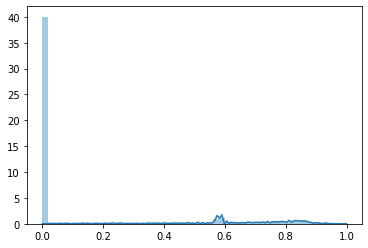

In [9]:
sns.distplot(y_scaled);

High Risk: 93
Low Risk: 8799
Percent High Risk: 1.0458839406207827


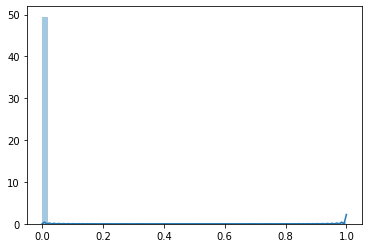

In [10]:
y_scaled_ = np.zeros(y_scaled.shape[0])
for i in range(y_scaled.shape[0]):
    y_scaled_[i] = y[i] >= -6
sns.distplot(y_scaled_)

y_High_risk = np.sum(y_scaled_==1)
y_Low_risk = np.sum(y_scaled_==0)
y_risk_percent = 100*y_High_risk/(y_Low_risk+y_High_risk)
print(f"High Risk: {y_High_risk}")
print(f"Low Risk: {y_Low_risk}")
print(f"Percent High Risk: {y_risk_percent}")

### Processing Test Data

In [11]:
df_test = pd.read_csv("test_data.csv")

#Dropping first the empty column 
df_test = df_test.drop("c_rcs_estimate", axis=1)

#OHE for c_object_type (5 categories) -> 5 new features
df_test = pd.get_dummies(df_test)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df_test = encoder.fit_transform(df_test)

df_test

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
0,0,6.842095,0,0,0,0,1,-7.296967,-7.208941,1.787894,31816.0,7929.0,-365.5,26967.0,16880.6,-26.3,-4207.7,6720.9,1.0,0.0,7.50,7.49,215,214,99.4,1.293,0.4344,0.015128,0.016234,0.000018,7084.698187,0.003744,98.217983,-0.270354,-0.657060,0.196264,0.210330,-0.997253,-0.142771,-0.998425,0.216358,0.656637,-0.155433,0.456629,-0.108973,-0.086419,0.081347,-0.456798,180.0,2.0,29.45,29.44,18.0,17.0,83.3,4.113,0.308274,0.106612,0.000379,7082.280567,0.004097,74.114497,-0.012443,-0.589099,0.063823,0.017109,-0.999983,-0.064830,-0.999539,-0.015848,0.588556,0.011187,0.182553,-0.142693,-0.506554,0.142522,-0.178864,1.5,2.0,733.085558,680.036816,733.157975,675.129158,-66.171283,57.950882,0.190036,52.081328,7.748198e+07,4.812243e+16,7.414544,212.775210,359.072138,28182.398762,4.557019,45.386672,0.371943,29.669476,0.007763,0.223996,0.011833,1.375099,76.0,74.0,29.0,11.0,0,0,0,0,1
1,0,6.571818,0,0,0,0,1,-7.282496,-7.199833,1.759386,31095.0,7929.0,-361.8,26356.6,16497.2,-25.6,-4207.7,6720.9,1.0,0.0,7.50,7.49,215,214,99.4,1.293,0.4344,0.015128,0.016234,0.000018,7084.697461,0.003744,98.217984,-0.273973,-0.656964,0.199647,0.212957,-0.997155,-0.145260,-0.998472,0.220856,0.656541,-0.158922,0.456633,-0.110415,-0.086295,0.082320,-0.456824,180.0,2.0,29.45,29.44,18.0,17.0,83.3,4.113,0.308274,0.106612,0.000379,7082.282379,0.004097,74.114498,-0.011881,-0.588955,0.064956,0.016580,-0.999983,-0.065971,-0.999553,-0.015964,0.588383,0.011270,0.182546,-0.143287,-0.507868,0.143116,-0.178881,1.5,2.0,733.085727,680.035195,733.159131,675.131626,-66.174477,57.950882,0.184979,51.832431,7.452485e+07,4.752620e+16,7.413035,212.758643,352.579069,27984.451040,4.556956,45.426864,0.364986,29.460828,0.007762,0.223983,0.011833,1.375117,75.0,74.0,24.0,9.0,0,0,0,0,1
2,0,6.112986,0,0,0,0,1,-7.316053,-7.217886,1.824263,32202.0,7929.0,-370.7,27294.4,17085.1,-26.6,-4207.7,6720.9,1.0,0.0,7.79,7.79,209,208,99.5,1.298,0.4344,0.014540,0.020434,0.000017,7084.698697,0.003744,98.218012,-0.361151,-0.560374,0.235602,0.295058,-0.996456,-0.183190,-0.998904,0.317612,0.559722,-0.250362,0.422270,-0.110323,0.025867,0.085265,-0.423264,180.0,2.0,29.45,29.44,18.0,17.0,83.3,4.113,0.308274,0.106612,0.000379,7082.279019,0.004097,74.114497,-0.013286,-0.589183,0.063440,0.017940,-0.999983,-0.064445,-0.999520,-0.015601,0.588660,0.010952,0.182607,-0.142473,-0.505868,0.142302,-0.178876,1.5,2.0,733.086160,680.037234,733.156904,675.127135,-66.169549,57.950882,0.192204,63.876219,5.821566e+07,4.833258e+16,7.834560,212.784398,295.356632,28256.047140,4.273193,45.365681,0.303518,29.747208,0.008190,0.223999,0.

In [12]:
# Getting X_test
X_test = df_test.sort_values('time_to_tca',ascending=False).groupby('event_id').tail(1)
X_test = X_test.sort_values('event_id')

# First Approach: Drop all columns with any NaN value
X_test = X_test.dropna(axis=1, how='any')

# Set event_id as index
X_test.set_index("event_id", inplace=True)

X_test

,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.228761,0,0,0,0,1,-7.332267,-7.227312,1.863127,32792.0,7929.0,-375.6,27793.8,17399.4,-27.1,-4207.7,6720.9,1.0,0.0,6.62,6.62,242,241,99.5,1.075,0.012410,0.020745,0.000014,7084.699726,0.003744,98.218015,-0.651483,-0.356146,0.292950,180.0,2.0,29.45,29.44,18.0,17.0,83.3,4.113,0.308274,0.106612,0.000379,7082.277004,0.004097,74.114496,-0.014579,-0.589305,0.062886,1.50,2.0,733.086815,680.038638,733.155531,675.124476,-66.166942,57.950882,0.195817,260.590619,1.148942e+06,4.858775e+16,5.833502,212.798144,62.328701,28349.650792,4.173933,45.332924,0,0,0,0,1
1,2.129518,0,0,0,1,0,-7.933674,-5.528562,8.701856,935.0,63.0,478.6,-779.0,196.9,-53.4,-27.6,20.9,1.0,0.0,6.61,6.61,207,207,99.4,0.997,0.018384,0.011079,0.000012,7170.601850,0.000739,98.706633,0.207413,0.297498,0.051009,1.0,0.0,14.48,14.48,26.0,24.0,98.6,1.029,0.345921,0.217909,0.000296,7119.515214,0.010989,98.756419,-0.040085,0.592206,0.101123,4.12,2.0,797.765439,787.164261,819.616171,663.140258,70.513190,37.134694,57.043790,5.070173,1.589709e+06,1.887353e+13,7.668534,95.178865,42.408877,815.099642,4.151353,70.402924,0,0,0,0,1
2,2.287244,0,0,0,1,1,-30.000000,-5.841035,389.260270,30488.0,9279.0,-325.8,-23962.4,-18848.1,33.2,-5737.5,7293.6,1.0,0.0,4.04,4.05,455,455,99.2,1.264,0.020731,0.014828,0.000015,7062.079675,0.000549,98.184153,-0.087434,-0.016364,0.037929,1.0,0.0,6.42,6.43,36.0,36.0,99.3,2.021,1.972867,0.277907,0.001536,7055.259147,0.001632,98.268723,-0.589164,0.093741,-0.010029,21.00,2.0,687.821934,680.063416,688.635518,665.608776,79.541510,51.809691,-0.204983,395.819448,1.423435e+04,3.920972e+11,1.509891,23.247498,47.704255,2917.758473,1.664111,11.493593,0,0,0,0,1
3,2.103093,0,0,1,0,0,-30.000000,-6.890421,139.385422,12287.0,10503.0,1115.7,-8708.5,-8596.3,43.0,-7374.6,7479.1,1.0,0.0,3.46,3.46,2751,2751,99.3,1.080,0.007600,0.001413,0.000007,7084.771599,0.001248,91.939061,0.041378,-0.467537,-0.062065,1.0,0.0,32.01,32.01,19.0,18.0,100.0,2.392,0.605262,0.134430,0.000677,7059.437452,0.005757,98.958313,0.237534,-0.539320,-0.309534,5.10,2.0,715.476875,697.792323,721.941904,640.659000,80.940732,45.403085,-0.234562,74.421941,1.459433e+04,4.975731e+14,3.918112,95.736033,23.986840,1913.582765,1.457081,152.653431,0,0,0,0,1
4,2.083777,0,0,1,0,1,-30.000000,-7.389872,314.832717,22356.0,14323.0,136.6,6959.3,21245.7,9.4,-13612.5,4458.3,1.0,0.0,3.72,3.72,470,469,98.4,1.166,0.012294,0.001961,0.000040,6995.837900,0.002967,97.842828,-0.128809,0.175205,-0.019724,1.0,0.0,6.42,6.42,42.0,42.0,99.3,1.314,0.826453,0.473670,0.001537,7031.066828,0.003030,86.325671,-0.300691,-0.117041,-0.031371,1.00,2.0,638.456229,596.945571,674.236963,631.622694,80.776288,18.134405,-0.037600,559.457161,5.833318e+04,3.449952e+12,3.769634,30.660987,56.631034,3556.931262,1.158802,18.025759,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [13]:
# Scaling
X_test_scaler = MinMaxScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

print(X_test_scaled.shape)
X_test_scaled

(2167, 74)


array([[0.04690203, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.0265356 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.05890367, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.03000248, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05411616, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00620924, 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

### Neural Network model

In [14]:
import tensorflow as tf
from tensorflow.keras import Model, optimizers, losses
from tensorflow.keras.layers import Input, Dense

In [15]:
# Model
input_shape = X_scaled.shape[1]
inputs_1 = Input(shape=(input_shape))
dense_1 = Dense(64, activation='relu')(inputs_1)
dense_2 = Dense(52, activation='relu')(dense_1)
dense_3 = Dense(32, activation='relu')(dense_2)
dense_4 = Dense(16, activation='relu')(dense_3)
dense_5 = Dense(8, activation='relu')(dense_4)
output_1 = Dense(1, activation = 'linear')(dense_5)

model_ffn = Model(inputs=inputs_1, outputs = output_1)

opt = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
loss_ = losses.mean_squared_error

model_ffn.compile(optimizer=opt,loss = loss_, metrics =['mse'])
print(model_ffn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4800      
_________________________________________________________________
dense_1 (Dense)              (None, 52)                3380      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1696      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9     

In [16]:
# Train
batch_size = 64
epochs = 200
model_ffn.fit(X_scaled, y_scaled, shuffle=True, batch_size=batch_size, epochs=epochs)

Train on 8892 samples
Epoch 1/200
8892/8892 [==============================] - 3s 313us/sample - loss: 0.0526 - mse: 0.0526
Epoch 2/200
8892/8892 [==============================] - 1s 68us/sample - loss: 0.0460 - mse: 0.0460
Epoch 3/200
8892/8892 [==============================] - 1s 67us/sample - loss: 0.0443 - mse: 0.0443
Epoch 4/200
8892/8892 [==============================] - 0s 44us/sample - loss: 0.0426 - mse: 0.0426
Epoch 5/200
8892/8892 [==============================] - 0s 55us/sample - loss: 0.0417 - mse: 0.0417
Epoch 6/200
8892/8892 [==============================] - 0s 49us/sample - loss: 0.0404 - mse: 0.0404
Epoch 7/200
8892/8892 [==============================] - 1s 59us/sample - loss: 0.0404 - mse: 0.0404
Epoch 8/200
8892/8892 [==============================] - 0s 44us/sample - loss: 0.0397 - mse: 0.0397
Epoch 9/200
8892/8892 [==============================] - 0s 32us/sample - loss: 0.0385 - mse: 0.0385
Epoch 10/200
8892/8892 [==============================] - 0s 39us/sa

8892/8892 [==============================] - 0s 36us/sample - loss: 0.0160 - mse: 0.0160
Epoch 82/200
8892/8892 [==============================] - 0s 26us/sample - loss: 0.0145 - mse: 0.0145
Epoch 83/200
8892/8892 [==============================] - 0s 26us/sample - loss: 0.0145 - mse: 0.0145
Epoch 84/200
8892/8892 [==============================] - 0s 34us/sample - loss: 0.0144 - mse: 0.0144
Epoch 85/200
8892/8892 [==============================] - 0s 39us/sample - loss: 0.0144 - mse: 0.0144
Epoch 86/200
8892/8892 [==============================] - 1s 75us/sample - loss: 0.0145 - mse: 0.0145
Epoch 87/200
8892/8892 [==============================] - 1s 69us/sample - loss: 0.0156 - mse: 0.0156
Epoch 88/200
8892/8892 [==============================] - 0s 38us/sample - loss: 0.0136 - mse: 0.0136
Epoch 89/200
8892/8892 [==============================] - 0s 33us/sample - loss: 0.0144 - mse: 0.0144
Epoch 90/200
8892/8892 [==============================] - 0s 46us/sample - loss: 0.0135 - mse: 

8892/8892 [==============================] - 0s 23us/sample - loss: 0.0079 - mse: 0.0079
Epoch 161/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.0086 - mse: 0.0086
Epoch 162/200
8892/8892 [==============================] - 0s 26us/sample - loss: 0.0090 - mse: 0.0090
Epoch 163/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.0083 - mse: 0.0083
Epoch 164/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.0087 - mse: 0.0087
Epoch 165/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.0099 - mse: 0.0099
Epoch 166/200
8892/8892 [==============================] - 0s 23us/sample - loss: 0.0084 - mse: 0.0084
Epoch 167/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.0079 - mse: 0.0079
Epoch 168/200
8892/8892 [==============================] - 0s 23us/sample - loss: 0.0099 - mse: 0.0099
Epoch 169/200
8892/8892 [==============================] - 0s 24us/sample - loss: 0.008

In [17]:
# Predict
predictions_scaled = model_ffn.predict(X_test_scaled)
predictions = y_scaler.inverse_transform(predictions_scaled)

print(predictions.shape)
predictions

(2167, 1)


array([[-18.262083],
       [-11.402334],
       [-30.449202],
       ...,
       [-30.218815],
       [-30.001661],
       [-29.677805]], dtype=float32)

In [32]:
'''predictions = X_test['risk'].apply(lambda x: x+1.9).values.reshape(-1, 1)
predictions'''

array([[ -5.43226695],
       [ -6.03367407],
       [-28.1       ],
       ...,
       [-28.1       ],
       [-11.58439105],
       [-23.22796033]])

In [33]:
# Create predictions array with event_id's
ids = np.arange(0,predictions.shape[0]).reshape(-1, 1)
y_test = np.concatenate((ids,predictions), axis=1)
print(y_test.shape)
y_test

(2167, 2)


array([[ 0.00000000e+00, -5.43226695e+00],
       [ 1.00000000e+00, -6.03367407e+00],
       [ 2.00000000e+00, -2.81000000e+01],
       ...,
       [ 2.16400000e+03, -2.81000000e+01],
       [ 2.16500000e+03, -1.15843911e+01],
       [ 2.16600000e+03, -2.32279603e+01]])

In [34]:
# Create submision csv
df_submission = pd.DataFrame(y_test,columns={"event_id", "predicted_risk"})
df_submission.to_csv("submision_v1_FNN.csv", sep=",", index=False)